# Lab 5 : Mixture Models+Model orden selection 

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD5"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L5_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

$\mu = \frac{1}{n} \sum_{i=1}^n x_i$

## EM - Algo
<img src="EM algo.png" alt="Description" width="1000"/>



In [20]:
from scipy.stats import multivariate_normal

class my_GMM:
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array containing covariance matrix
        cond_prob_: (n, k) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X, n_iter=100):
        """ Find the parameters that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        def compute_condition_prob_matrix(X, alpha, mu, Sigma):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            n, p = X.shape
            matrix = np.zeros((n, self.k)) 
            for j in range(self.k):
                matrix[:, j] = alpha[j] * multivariate_normal.pdf(X, mean=mu[j], cov=Sigma[j])  
            # Normalize the rows so each row sums to 1
            for i in range(n):
                row_sum = matrix[i, :].sum()
                matrix[i, :] /= row_sum  
            return matrix
        
        # Initialize the labels
        n, p = X.shape
        labels = np.random.randint(0, self.k, size=n)
        # One-hot encoding
        label_matrix = np.zeros((n, self.k))  
        for i in range(n):
            label_matrix[i, labels[i]] = 1 
        self.labels_ = labels  
        
        # Initialize the parameters of the GMM given the (X, labels)
        self.alpha_ = np.array([np.sum(labels == j) for j in range(self.k)]) / n  #shape (k)
        self.mu_ = np.array([X[labels == j].mean(axis=0) for j in range(self.k)])  # shape (k, p)
        self.Sigma_ = np.array([np.cov(X[labels == j].T) for j in range(self.k)])  # shape (k, p, p)
        
        # EM
        for t in range(n_iter): ## could also use a epsilon to have early stopping when convergence is ok
            # E-step: shape (n, k)
            self.cond_prob_ = compute_condition_prob_matrix(X, self.alpha_, self.mu_, self.Sigma_) 
            
            # M-step
            for k in range(self.k):
                self.alpha_[k] = (1/n) * np.sum(self.cond_prob_[:, k]) 
                
            for k in range(self.k):
                self.mu_[k, :] = (1 / (n * self.alpha_[k])) * (X.T @ self.cond_prob_[:, k])  
                
            for k in range(self.k):
                diff = X - self.mu_[k, :]
                self.Sigma_[k] = (1 / (n * self.alpha_[k])) * (diff.T @ (diff * self.cond_prob_[:, k][:, np.newaxis])) 

            # Update labels_
            self.labels_ = np.argmax(self.cond_prob_, axis=1)  
        
        return self
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assignment        
        """
        n, p = X.shape
        probas = np.zeros((n, self.k))  
        for j in range(self.k):
            probas[:, j] = self.alpha_[j] * multivariate_normal.pdf(X, mean=self.mu_[j], cov=self.Sigma_[j])  
        return np.argmax(probas, axis=1)

        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n, p = X.shape
        probas = np.zeros((n, self.k))  
        for j in range(self.k):
            probas[:, j] = self.alpha_[j] * multivariate_normal.pdf(X, mean=self.mu_[j], cov=self.Sigma_[j])  
        # Normalize each row so the probabilities sum to 1
        for i in range(n):
            row_sum = probas[i, :].sum()
            probas[i, :] /= row_sum          
        return probas


Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

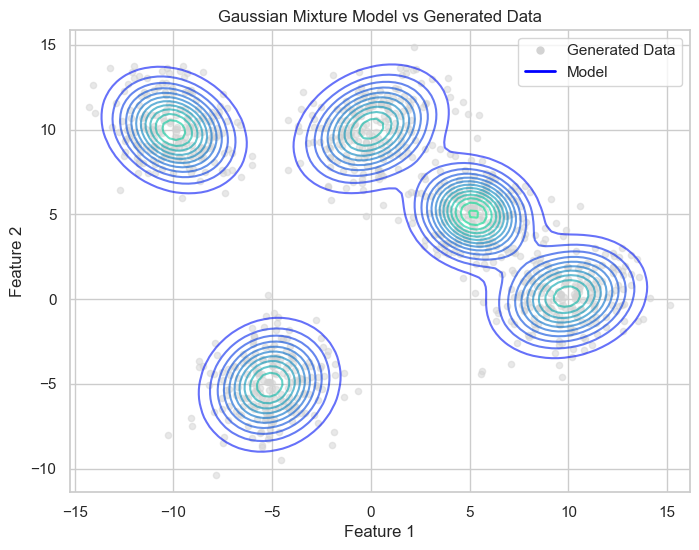

In [21]:
from matplotlib.lines import Line2D

# Parameters for five distinct Gaussian distributions with overlap
means = [
    [0, 10],
    [5, 5],
    [10, 0],
    [-5, -5],
    [-10, 10]
]
covariances = [
    [[3, 0.8], [0.8, 3]],
    [[3, -0.5], [-0.5, 3]],
    [[3, 0.7], [0.7, 3]],
    [[3, 0.3], [0.3, 3]],
    [[3, -0.6], [-0.6, 3]]
]

data_points = [np.random.multivariate_normal(mean, cov, size=200) for mean, cov in zip(means, covariances)]
X = np.vstack(data_points)

# Fit a custom Gaussian Mixture Model
gmm = my_GMM(k=5)
gmm.fit(X,n_iter=1000)

# density estimation
x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
X_grid, Y_grid = np.meshgrid(x, y)
XY_grid = np.array([X_grid.ravel(), Y_grid.ravel()]).T
probabilities = np.zeros(XY_grid.shape[0])
for j in range(gmm.k):
    probabilities += gmm.alpha_[j] * multivariate_normal.pdf(XY_grid, mean=gmm.mu_[j], cov=gmm.Sigma_[j])

# Reshape the probability densities to match the grid shape for contour plotting
Z = probabilities.reshape(X_grid.shape)

# Plot the generated data and model density
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], color="lightgrey", alpha=0.5, s=20, label="Generated Data")
plt.contour(X_grid, Y_grid, Z, levels=15, cmap="winter", alpha=0.6)

# visual elements - not important
contour_legend = Line2D([0], [0], color="blue", lw=2, label="Model")
plt.legend(handles=[Line2D([], [], color="lightgrey", marker='o', markersize=5, lw=0, label="Generated Data"), contour_legend])
plt.title("Gaussian Mixture Model vs Generated Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
